In [1]:
# Visualizes the location visit durations across different demographic (e.g., emplotyment) and mental health (e.g. depression)
# groups

import pickle
import os
import numpy as np
import pandas as pd

# reading top locations
with open('top_locations.dat') as f:
    location_top = pickle.load(f)
f.close()

# reading assessments
with open('../Assessment/assessment.dat') as f:
    data = pickle.load(f)
f.close()

# reading demographics
with open('../Demographics/demo.dat') as f:
    demo = pickle.load(f)
f.close()

# adding demo to dataframe
data.insert(loc=len(data.columns), column='gender', value=np.nan)
data.insert(loc=len(data.columns), column='age', value=np.nan)
data.insert(loc=len(data.columns), column='employment', value=np.nan)

for (i,subj) in enumerate(data['ID']):
    ind = np.where(demo['ID']==subj)[0][0]
    data.loc[i,'gender'] = demo.loc[ind, 'gender']
    data.loc[i,'age'] = demo.loc[ind, 'age']
    data.loc[i,'employment'] = demo.loc[ind, 'employment']

# adding durations to dataframes
for loc_top in location_top:
    data.insert(loc=len(data.columns), column=loc_top, value=np.nan)

folders = os.listdir('data/')
for fol in folders:
    ind_subject = np.where(data['ID']==fol)[0][0]
    subfolders = os.listdir('data/'+fol)
    data.loc[ind_subject, location_top] = 0
    dur_all = 0
    for subf in subfolders:
        file_eml = 'data/'+fol+'/'+subf+'/eml.csv'
        file_fus = 'data/'+fol+'/'+subf+'/fus.csv'
        if os.path.exists(file_eml) and os.path.exists(file_fus):
            df = pd.read_csv(file_eml, sep='\t', header=None)
            loc = df.loc[0,6][2:-2]
            df = pd.read_csv(file_fus, sep='\t', header=None)
            t = np.array(df.loc[:,0])
            tdiff = t[1:]-t[:-1]
            tdiff = tdiff[tdiff<600]
            dur = np.sum(tdiff)

            if loc in location_top:
                data.loc[ind_subject, loc] += dur
            dur_all += dur
    data.loc[ind_subject, location_top] /= dur_all #normalize


In [8]:
def remove_parentheses(ss):
    ss = np.array(ss)
    for i in range(ss.size):
        s = ss[i].split('(')
        s = s[0]
        ss[i] = s
    return ss

<IPython.core.display.Javascript object>


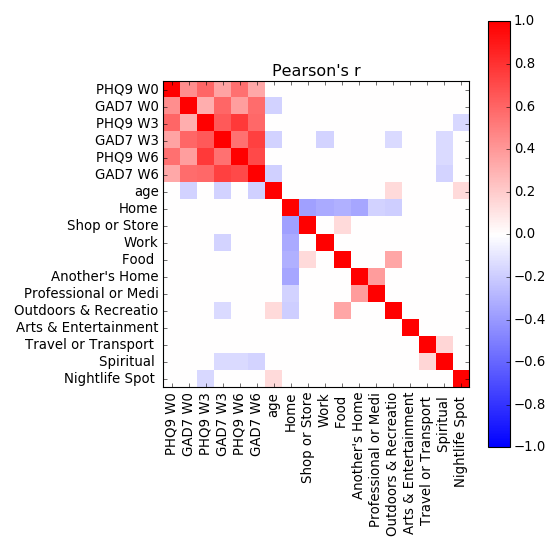

In [10]:
# correlation matrix

from soplata import *
from utils import *

data_new = data.drop(['ID','SPIN W0','SPIN W3','SPIN W6','gender','employment','age'],axis=1)
data_cov, pval = calculate_covariance(data_new.values.astype(float))

#%matplotlib inline
%matplotlib notebook

# truncate labels
# labs = [lab[0:20] for lab in data_new.columns]
labs = remove_parentheses(labs)

data_cov[pval>=0.05]=0

plot_confusion_matrix(data_cov, labels=labs, cmap=plt.cm.bwr, xsize=7, ysize=7, title='Pearson\'s r')


<IPython.core.display.Javascript object>


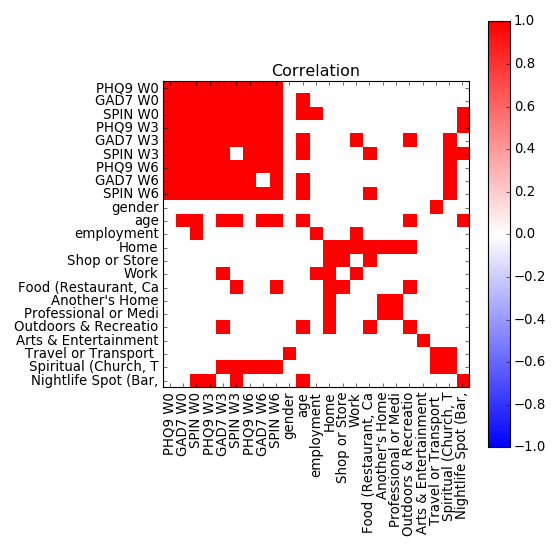

In [3]:
plot_confusion_matrix(pval<0.05, labels=labs, cmap=plt.cm.bwr, xsize=7, ysize=7)

In [77]:
# only mental health vars vs semantic locaiton

from scipy.stats import pearsonr, spearmanr

target = data_new[['PHQ9 W0','PHQ9 W3','PHQ9 W6','GAD7 W0','GAD7 W3','GAD7 W6']]
location = data_new.drop(['PHQ9 W0','PHQ9 W3','PHQ9 W6','GAD7 W0','GAD7 W3','GAD7 W6','age'],axis=1)

r = pd.DataFrame(index=location.columns, columns=target.columns)
p = pd.DataFrame(index=location.columns, columns=target.columns)
tab = pd.DataFrame(index=location.columns, columns=target.columns, dtype=string)
for tar in target.columns:
    for loc in location.columns:
        x = target.loc[:,tar].astype(float)
        y = location.loc[:,loc].astype(float)
        indnan = np.where(np.logical_or(np.isnan(x),np.isnan(y)))[0]
        x = x.drop(indnan)
        y = y.drop(indnan)
        x = x.reset_index(drop=True)
        y = y.reset_index(drop=True)
        rr,pp = pearsonr(x,y)
        r.loc[loc,tar] = rr
        p.loc[loc,tar] = pp


In [79]:
p

,PHQ9 W0,PHQ9 W3,PHQ9 W6,GAD7 W0,GAD7 W3,GAD7 W6
Home,0.412678,0.353146,0.229824,0.228533,0.169412,0.160916
Shop or Store,0.808102,0.840885,0.754119,0.952107,0.663322,0.612892
Work,0.236573,0.0599694,0.0519407,0.247542,0.0140467,0.225681
"Food (Restaurant, Cafe)",0.668921,0.332936,0.0661182,0.723338,0.172463,0.223
Another's Home,0.561818,0.367169,0.361315,0.796682,0.926665,0.993042
Professional or Medical Office,0.742287,0.232415,0.563866,0.312649,0.835209,0.503803
Outdoors & Recreation,0.8151,0.101726,0.159854,0.304508,0.059491,0.110118
"Arts & Entertainment (Theater, Music Venue, Etc.)",0.0825541,0.416439,0.599434,0.637592,0.745949,0.82703
"Travel or Transport (Airport, Bus Stop, Train Station, Etc.)",0.372874,0.671301,0.110726,0.2148,0.923135,0.212212
"Spiritual (Church, Temple, Etc.)",0.56234,0.329992,0.04207,0.202382,0.054343,0.0209421


In [88]:
# only mental health vars vs semantic locaiton - with bootstrap

from scipy.stats import pearsonr, spearmanr

n_bs = 1000

corr_med = pd.DataFrame(index=location.columns, columns=target.columns)
corr_hi = pd.DataFrame(index=location.columns, columns=target.columns)
corr_lo = pd.DataFrame(index=location.columns, columns=target.columns)
for tar in target.columns:
    for loc in location.columns:
        x = target.loc[:,tar].astype(float)
        y = location.loc[:,loc].astype(float)
        indnan = np.where(np.logical_or(np.isnan(x),np.isnan(y)))[0]
        x = x.drop(indnan)
        y = y.drop(indnan)
        x = x.reset_index(drop=True)
        y = y.reset_index(drop=True)
        r = np.zeros([n_bs])
        p = np.zeros([n_bs])
        for bs in range(n_bs):
            ind = np.random.choice(np.arange(x.size), size=x.size, replace=True)
            x_s = x.loc[ind]
            y_s = y.loc[ind]
            r[bs],p[bs] = pearsonr(x_s,y_s)
        corr_med.loc[loc,tar] = np.median(r)
        corr_hi.loc[loc,tar] = np.percentile(r, 97.5)
        corr_lo.loc[loc,tar] = np.percentile(r, 2.5)

In [81]:
# print the table



,PHQ9 W0,PHQ9 W3,PHQ9 W6,GAD7 W0,GAD7 W3,GAD7 W6
Home,0.0573247,0.0679028,0.0827832,0.0851759,0.100679,0.103757
Shop or Store,-0.0129538,0.0103893,-0.0205261,-0.00364402,-0.0300478,-0.0377728
Work,-0.0819353,-0.130929,-0.137868,-0.0770981,-0.175633,-0.0832768
"Food (Restaurant, Cafe)",-0.0287225,-0.0725299,-0.133465,-0.0268015,-0.0966397,-0.0849696
Another's Home,0.0423691,-0.0629364,-0.0667203,-0.0157228,-0.0139148,0.000692015
Professional or Medical Office,0.0303044,0.0977077,0.0508167,-0.0664287,0.0197881,0.0528879
Outdoors & Recreation,0.0144595,-0.122975,-0.103785,-0.0700667,-0.132513,-0.112074
"Arts & Entertainment (Theater, Music Venue, Etc.)",-0.123087,-0.0574555,-0.0436365,0.0324196,0.0231844,-0.0152325
"Travel or Transport (Airport, Bus Stop, Train Station, Etc.)",-0.0610862,-0.0297253,-0.112168,0.0832211,0.00197234,-0.0894895
"Spiritual (Church, Temple, Etc.)",-0.0376552,-0.080505,-0.144015,-0.095035,-0.149511,-0.165547


In [89]:
np.sign(corr_hi)+np.sign(corr_lo)

,PHQ9 W0,PHQ9 W3,PHQ9 W6,GAD7 W0,GAD7 W3,GAD7 W6
Home,0,0,0,0,0,0
Shop or Store,0,0,0,0,0,0
Work,0,0,0,0,-2,0
"Food (Restaurant, Cafe)",0,0,0,0,0,0
Another's Home,0,0,0,0,0,0
Professional or Medical Office,0,2,0,0,0,0
Outdoors & Recreation,0,0,0,0,0,0
"Arts & Entertainment (Theater, Music Venue, Etc.)",-2,0,0,0,0,0
"Travel or Transport (Airport, Bus Stop, Train Station, Etc.)",0,0,-2,0,0,-2
"Spiritual (Church, Temple, Etc.)",0,0,-2,0,-2,-2


In [82]:
corr_lo

,PHQ9 W0,PHQ9 W3,PHQ9 W6,GAD7 W0,GAD7 W3,GAD7 W6
Home,-0.0938766,-0.0769106,-0.0740161,-0.0673491,-0.0391778,-0.0430777
Shop or Store,-0.157566,-0.100031,-0.146719,-0.150007,-0.101933,-0.148567
Work,-0.238637,-0.292807,-0.282707,-0.206822,-0.307073,-0.209044
"Food (Restaurant, Cafe)",-0.147125,-0.233209,-0.24236,-0.138997,-0.245521,-0.195617
Another's Home,-0.0318702,-0.189358,-0.187026,-0.12901,-0.120285,-0.105769
Professional or Medical Office,-0.0464097,0.0309267,-0.0350768,-0.155529,-0.0554237,-0.0133172
Outdoors & Recreation,-0.107283,-0.215191,-0.182887,-0.159772,-0.240975,-0.239034
"Arts & Entertainment (Theater, Music Venue, Etc.)",-0.221006,-0.216291,-0.167414,-0.0941299,-0.0897894,-0.115998
"Travel or Transport (Airport, Bus Stop, Train Station, Etc.)",-0.137769,-0.119004,-0.188217,-0.0443278,-0.090643,-0.137058
"Spiritual (Church, Temple, Etc.)",-0.135508,-0.220677,-0.236993,-0.194202,-0.262004,-0.268418
